# SVG中的闭合图像排序

> 在处理SVG矢量图片中，需要将图片中的大小不同的path路径图片在SVG中重新排列，参照ai给的建议使用python中的库svgpathtools进行。

## 1. 介绍
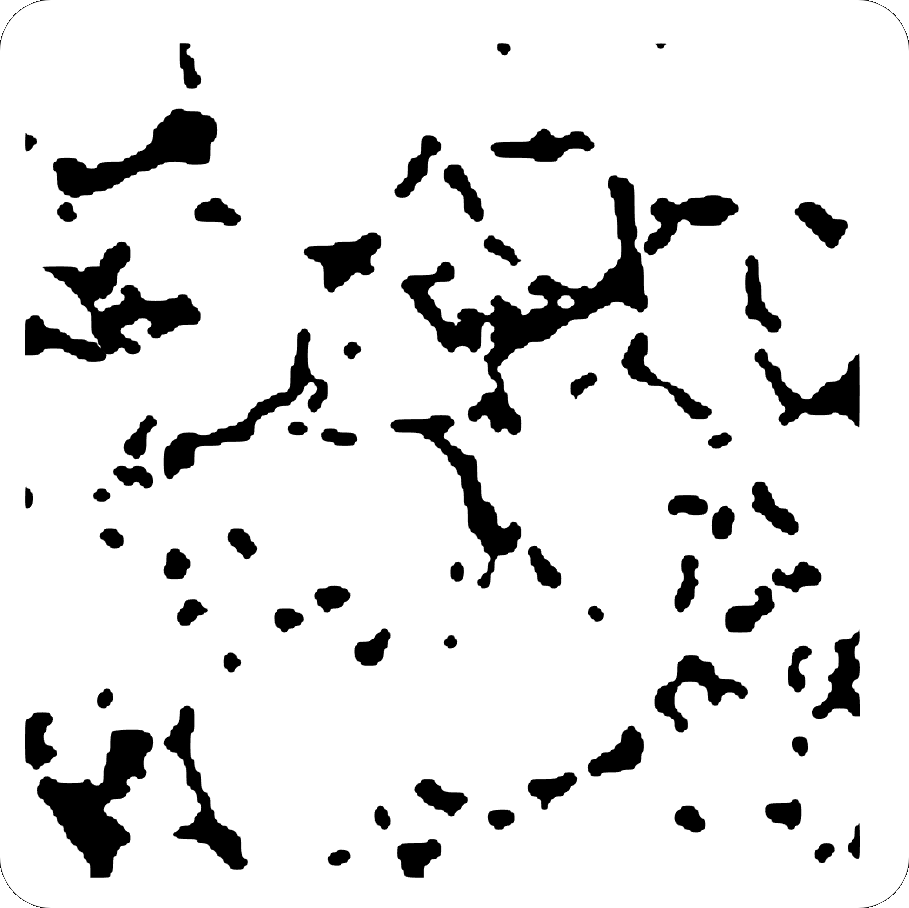

### 代码演示
1. 导入库和读取SVG文件

In [32]:
from svgpathtools import parse_path, svg2paths
import os

# 定义数据
svg_file_path = 'snapshot.png2.svg'
if not os.path.exists(svg_file_path):
    print(f"❌ 找不到文件: {svg_file_path}，请检查路径。")
else:
    # 2. 自动提取所有 path 和属性
    # paths 包含了几何信息，attributes 包含了颜色等 XML 属性
    paths, attributes = svg2paths(svg_file_path)

    # 3. 建立一个列表存储 (路径对象, 面积, 原始属性)
    path_data_list = []
    for i, p in enumerate(paths):
        try:
            area = abs(p.area())
            path_data_list.append({
                'id': i,
                'path': p,
                'area': area,
                'color': attributes[i].get('fill', '#000000')
            })
        except Exception as e:
            print(f"⚠️ 图形 {i} 无法计算面积（可能是路径未闭合）: {e}")

⚠️ 图形 1 无法计算面积（可能是路径未闭合）: 
⚠️ 图形 2 无法计算面积（可能是路径未闭合）: 
⚠️ 图形 18 无法计算面积（可能是路径未闭合）: 


2. 解析并计算

In [33]:
sorted_list = sorted(path_data_list, key=lambda x: x['area'], reverse=True)

print(f"✅ 成功读取 {len(sorted_list)} 个有效图形！\n")

# 5. 打印排序结果
print("--- 面积排序结果 ---")
for rank, item in enumerate(sorted_list, 1):
    print(f"排名 {rank}: 图形 ID {item['id']} | 面积: {item['area']:.2f} | 颜色: {item['color']}")

✅ 成功读取 39 个有效图形！

--- 面积排序结果 ---
排名 1: 图形 ID 35 | 面积: 161082.55 | 颜色: #000000
排名 2: 图形 ID 3 | 面积: 90283.00 | 颜色: #000000
排名 3: 图形 ID 0 | 面积: 55569.70 | 颜色: #000000
排名 4: 图形 ID 33 | 面积: 53206.90 | 颜色: #000000
排名 5: 图形 ID 37 | 面积: 52379.95 | 颜色: #000000
排名 6: 图形 ID 13 | 面积: 50165.95 | 颜色: #000000
排名 7: 图形 ID 25 | 面积: 49424.70 | 颜色: #000000
排名 8: 图形 ID 9 | 面积: 36247.30 | 颜色: #000000
排名 9: 图形 ID 24 | 面积: 35226.60 | 颜色: #000000
排名 10: 图形 ID 4 | 面积: 34143.65 | 颜色: #000000
排名 11: 图形 ID 28 | 面积: 31806.25 | 颜色: #000000
排名 12: 图形 ID 16 | 面积: 31423.40 | 颜色: #000000
排名 13: 图形 ID 12 | 面积: 27125.25 | 颜色: #000000
排名 14: 图形 ID 14 | 面积: 26632.15 | 颜色: #000000
排名 15: 图形 ID 23 | 面积: 26370.85 | 颜色: #000000
排名 16: 图形 ID 29 | 面积: 24476.95 | 颜色: #000000
排名 17: 图形 ID 41 | 面积: 24431.85 | 颜色: #000000
排名 18: 图形 ID 34 | 面积: 24402.50 | 颜色: #000000
排名 19: 图形 ID 20 | 面积: 24302.20 | 颜色: #000000
排名 20: 图形 ID 11 | 面积: 22065.45 | 颜色: #000000
排名 21: 图形 ID 27 | 面积: 20460.55 | 颜色: #000000
排名 22: 图形 ID 17 | 面积: 19521.35 | 颜

In [35]:
import xml.etree.ElementTree as ET  # 关键点：必须加这一行，且注意大小写
from svgpathtools import svg2paths, wsvg
import os

# 1. 重新读取原图以获取尺寸限制 (假设原图是 svg_file_path)

# 1. 获取 SVG 原始尺寸函数
def get_svg_dimensions(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    # 尝试从 viewBox 读取 (格式通常为 "0 0 width height")
    viewbox = root.get('viewBox')
    if viewbox:
        _, _, w, h = map(float, viewbox.split())
        return w, h

    # 如果没有 viewBox，尝试读取 width 和 height 属性
    # 注意处理 "800pt" 或 "800px" 这种带单位的情况
    def parse_dim(dim_str):
        if not dim_str: return None
        return float(''.join(filter(lambda x: x.isdigit() or x == '.', dim_str)))

    w = parse_dim(root.get('width'))
    h = parse_dim(root.get('height'))
    # return w or 800.0, h or 900.0 # 兜底默认值
    return w , h  # 兜底默认值


if os.path.exists(svg_file_path):
    # 自动获取原图限宽
    MAX_WIDTH, ORIGINAL_HEIGHT = get_svg_dimensions(svg_file_path)
    print(f"📏 自动检测到原图宽度限制: {MAX_WIDTH}")

    paths, attributes = svg2paths(svg_file_path)

PADDING = 20        # 图形之间的间距
current_x = 0.0     # 当前 X 位置
current_y = 0.0     # 当前 Y 位置
row_max_height = 0.0 # 当前行中最高图形的高度

new_paths = []
new_attributes = []

# 按面积从小到大排序
small_to_large_list = sorted_list[::-1]

print(f"开始重排，目标最大宽度: {MAX_WIDTH}")

for item in small_to_large_list:
    path_obj = item['path']
    attr = attributes[item['id']].copy()

    # 获取当前图形的包围盒
    xmin, xmax, ymin, ymax = path_obj.bbox()
    width = xmax - xmin
    height = ymax - ymin

    # --- 换行检测逻辑 ---
    # 如果当前 X 坐标 + 图形宽度 超过了总宽度限制，且当前行已经有图形了，就换行
    if current_x + width > 8000 and current_x > 0:
        current_x = 0.0                      # X 回到开头
        current_y += row_max_height + PADDING # Y 向下移动（上一行最高高度 + 间距）
        row_max_height = 0.0                 # 重置新一行的最高高度

    # 计算位移量
    dx = current_x - xmin
    dy = current_y - ymin

    # 执行位移并存入列表
    moved_path = path_obj.translated(complex(dx, dy))
    new_paths.append(moved_path)
    new_attributes.append(attr)

    # 更新记录：
    # 1. 更新当前行的最大高度
    row_max_height = max(row_max_height, height)
    # 2. 更新下一个图形的 X 坐标
    current_x += width + PADDING

# 3. 保存新文件
output_filename = 'sorted_wrapped_output.svg'
wsvg(new_paths, attributes=new_attributes, filename=output_filename)

print(f"✨ 换行排列完成！文件已保存至: {output_filename}")

📏 自动检测到原图宽度限制: 800.0
开始重排，目标最大宽度: 800.0
✨ 换行排列完成！文件已保存至: sorted_wrapped_output.svg
